**<h1><center>CS 464</center></h1>**
**<h1><center>Introduction to Machine Learning</center></h1>**
**<h1><center>Spring 2022</center></h1>**
**<h1><center>Homework 3</center></h1>**
<h4><center>Due: DEC 23, 2022 23:59 (GMT+3)</center></h4>

In this third homework assignment, you are asked to develop a system that can be used to supply additional information to weather forecasts. For this task, you are provided a dataset that consists of weather images that belong to four different weather conditions: [cloudy, rain, shiny, sunrise]. Your model will classify images considering these class labels. 

For this assignment, **using PyTorch is mandatory.**

**Tip:** You may experience latencies in file I/O if you are using Google Colab. In this regard, we recommend you upload your data to Google Drive as a zip file and unzip the folder contents in your drive. If you would like to upload the data files separately, it may take significant time.

You will submit a single ipynb file as the homework submission. If you want to provide further explanation about your work, you can add Markdown cells to do so. [Here](https://www.markdownguide.org/), you can find a guide for Markdown syntax. Upload your homework with the following filename convention: \<BilkentID\>\_\<Name\>\_\<Surname\>.ipynb

**Contact:**
- [Yusuf Dalva](mailto:yusuf.dalva@bilkent.edu.tr)
- [Ahmet Burak Yıldırım](mailto:a.yildirim@bilkent.edu.tr)

**Dataset**<br>
You can find the dataset [here](https://www.kaggle.com/datasets/pratik2901/multiclass-weather-dataset). 


# **Q1** [12 points]
This part consists of 4 questions which you are expected to answer. Please fill in the following cell in Markdown format. Each question is worth 2 points.

a) Do we need to output the actual probability values when performing classification with the softmax layer? If not, how do these numbers represent the likelihood of classes? Also, does the output values should be in a specific range for us to make a classification? <br>

No, we do not need to output the actual probability values. These values represent the probability that the model assigns the input to the relative class. We need to output the index of the maximum value as this will be the prediction of the model according to the given input. As the output is a probability, these values should be between [0,1]. <br>

b) From the perspective of model complexity, how you can identify when a model underfits or overfits? Which plots are informative for detecting this behavior? <br>
Your model is overfitting your training data when you see that the model performs well on the training data but does not perform well on the test data. Your model is underfitting the training data when the model performs poorly on the training data. Accuracy - number of epochs plot can be used to visualize them. For overfitting, if the accuracy values are increasing rapidly for the training data while that it not the case for the test data, then we can state that the model overfitted the training data. For underfitting, if the accuracy values are not increasing enough for the training data, we can say that the model underfits the training data.


c) In neural networks, how does the ReLU function help us to generalize to complex feature spaces? Why we are not using linear layers only? <br>
ReLU function does the following:
<ul>
<li>if the value is smaller than 0 set it to 0</li>
<li>else keep the original value</li>
</ul>
This help us create a non-linear layer. In general, not all data is distributed linearly. Hence, using only linear layers can be insufficient. We can only detect linearly distributed input by using linear layers only. <br>

d) Assume that you are going to pass the feature matrix with dimensions 64x64x5 (Height x Width x Channel size) through a convolutional layer. If our convolutional layer has a kernel size of 3x3 and the number of filters is 6, how many learnable parameters are present? <br>

The number of learnable parameters is 6x3x3x5 + 6 = 456. <br>


# **Q2** [88 points]

## Necessary Imports
In the cell below, we import some utilities that you can make use of in this assignment. Note that you need to use PyTorch in this assignment. To report certain metrics (like precision, recall, accuracy) you may use utilities from *scikit-learn* library. You can edit these imports considering your implementation as long as you use PyTorch.

## Setup

In [3]:
import os 
import time
import random
from glob import glob

import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

import torch
from torch import optim
import torch.nn as nn
import torch.nn.functional as F
import torchvision.models as models
from torch.utils.data import Dataset, DataLoader

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, f1_score, precision_score, recall_score, accuracy_score
import seaborn as sns
import pandas as pd

You can test whether hardware acceleration with GPU is enabled in the cell below. In addition, if you have GPU access, you can check the amount of available GPU memory.

In [4]:
# setting device as GPU if available, else CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

# CUDA device information
if device.type == 'cuda':
    print('GPU Name:', torch.cuda.get_device_name(0))
    print('Memory Stats:')
    print('  - Allocated:', round(torch.cuda.memory_allocated(0)/1024**3,1), 'GB')
    print('  - Cached:   ', round(torch.cuda.memory_reserved(0)/1024**3,1), 'GB')
    print('  - Total:    ', round(torch.cuda.get_device_properties(0).total_memory/1024**3,1), 'GB')

Using device: cpu


**DO NOT CHANGE**<br>
To evaluate your implementation fairly, we set seed values for random sampling methods in PyTorch, Numpy, and Python random library. These seeds are set to evaluate your models successfully, so do not change these values.

In [5]:
# for reproducable results
torch.manual_seed(464)
torch.cuda.manual_seed(464)
np.random.seed(464)
random.seed(464)
if device.type == 'cuda':
    torch.backends.cudnn.deterministic=True

## Load Data [6 points]
In this assignment, you will use a custom dataset, which you need a wrapper class to access its data. For this purpose, implement a custom dataset class to organize data with the specifications you need. This class will load batches of data using a PyTorch DataLoader later. The class signature of CustomDataset class is provided to you in the cell below, where you can implement your custom dataset.

**IMPORTANT:** As you may have difficulties while fitting all images to your RAM, you need to read the images while getting that item (each item is an image here). We encourage you to read the data files in the "__getitem__" function to avoid encountering any issues related to fitting the data to memory. This way, you do not need to hold the dataset in a single variable, which would be memory intensive.

In [6]:
class CustomDataset(Dataset):
    def __init__(self, data, labels, **kwargs):
        self.labels = labels
        self.args = kwargs
        self.data = data
        self.data_partition = []
        self.len = 0
        #count the number of files in the data subdirectories
        for label in self.labels:
            self.len += len(os.listdir(os.path.join(self.data, label)))
            self.data_partition.append(len(os.listdir(os.path.join(self.data, label))))
             
    def __len__(self):
        return self.len

    def __getitem__(self, index):
        i = 0
        while index >= self.data_partition[i]:
            index -= self.data_partition[i]
            i += 1
        img_name = os.listdir(os.path.join(self.data, self.labels[i]))[index]

        img_name = os.path.join(self.data, self.labels[i], img_name)
        img = Image.open(img_name)
        img = img.convert('RGB')
        img = img.resize((224, 224))
        img = np.array(img)
        
        return  torch.tensor(img, dtype=torch.float32).permute(2,0,1) , i,


d = CustomDataset(data='Multi-class Weather Dataset/', labels=['Cloudy', 'Rain', 'Shine', 'Sunrise'])
print(d.data_partition)
print(d.__getitem__(1))

[300, 215, 253, 357]
(tensor([[[ 88.,  87.,  87.,  ..., 176., 175., 172.],
         [ 87.,  88.,  89.,  ..., 175., 174., 171.],
         [ 87.,  90.,  92.,  ..., 172., 171., 170.],
         ...,
         [ 66.,  77.,  81.,  ..., 206., 196., 195.],
         [ 84.,  81.,  83.,  ..., 208., 192., 194.],
         [ 89.,  86.,  87.,  ..., 204., 189., 192.]],

        [[156., 156., 155.,  ..., 194., 193., 190.],
         [156., 156., 156.,  ..., 193., 192., 189.],
         [158., 157., 156.,  ..., 190., 189., 188.],
         ...,
         [ 73.,  82.,  85.,  ..., 177., 172., 171.],
         [ 88.,  85.,  84.,  ..., 179., 167., 170.],
         [ 95.,  89.,  86.,  ..., 175., 164., 168.]],

        [[205., 205., 206.,  ..., 206., 205., 202.],
         [205., 205., 205.,  ..., 204., 203., 201.],
         [208., 207., 201.,  ..., 200., 199., 198.],
         ...,
         [ 28.,  33.,  34.,  ..., 119., 112., 111.],
         [ 38.,  32.,  30.,  ..., 121., 108., 110.],
         [ 39.,  31.,  30.,  ..

You can implement an additional function to read and construct custom dataset objects for training, validation, and test sets. While constructing the dataset, consider the following issues:
- Dataset contains images that end with prefixes *.jpg* and *.jpeg*.
- If you use PIL to read images, you should convert them to "RGB" format to operate on three color channels.
- Resize the dataset images to 224x224. You are going to design models that take images with tensor shape 224x224x3.
- If you wish, you can change the ordering of the color channels with np.moveaxis function

Lastly, the train-validation-test split for the dataset provided to you is 70-10-20 in terms of percentages. While constructing the dataset, remember that shuffling is a necessary step (to get randomly distributed classes across batches).

You can design your dataset getter method compatible with the line provided below, where train_dataset, val_dataset, and test_dataset are all instances of CustomDataset.

In [7]:
train_len = int(0.7 * d.__len__())
val_len = int(0.1 * d.__len__())
test_len = d.__len__() - train_len - val_len

assert train_len + val_len + test_len == d.__len__()

print(d.__len__())


train_dataset, val_dataset, test_dataset = torch.utils.data.random_split(d, [train_len, val_len, test_len])

1125


## Models [16 points]
In this assignment, you will implement one CNN (Convolutional Neural Network) model and one FCN (Fully-Connected Network) model, where the class signatures are provided below.

### Convolutional Neural Network (CNN) Model [8 points]
As the first model, you will implement a convolutional model. Your model will include 3 CONV + POOL blocks, which denotes one Convolutional layer followed by a Max Pooling Layer. The channel sizes for convolutional blocks are [16, 32, 64], respectively. For all convolutional layers, take kernel size as 3, stride as one, and apply padding such that convolutions do not change the shape on width and height dimensions. 
<br><br>
Following the convolutional part, you will perform image classification for the dataset provided to you. You can use ReLU activation as the non-linearity in your model (except the classification layer).

In [154]:
class ConvNet(nn.Module):
    '''Define your convolutional neural network'''
    def __init__(self, **kwargs):
        super(ConvNet, self).__init__()
        self.model = nn.Sequential(
            nn.Conv2d(3, 16, 3, 1, 1),
            nn.MaxPool2d(2, 2),
            nn.ReLU(),
            nn.Conv2d(16, 32, 3, 1, 1),
            nn.MaxPool2d(2, 2),
            nn.ReLU(),
            nn.Conv2d(32, 64, 3, 1, 1),
            nn.MaxPool2d(2, 2),
            nn.Flatten(),
            nn.Linear(64*28*28, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.Linear(64, 4),
            nn.Softmax(dim=1)
        )
        self.kwargs = kwargs


     
    def forward(self, x):
        return self.model(x)


### Fully Connected Network (FCN) Model [8 points]
The second model you will try is a Fully Connected Network composed of Linear layers and non-linear activation functions connected to each other. For this part, the number of features for your linear layers is [1024, 512, 256]. Again, you can use ReLU as your non-linear activation function in your model (except the classification layer).

In [150]:
class FCNet(nn.Module):
    '''Define your full connected network'''
    def __init__(self, **kwargs):
        super(FCNet,self).__init__()
        self.model = nn.Sequential(
            nn.Linear(224*224*3, 1024),
            nn.ReLU(),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Linear(256, 4),
        )
        self.kwargs = kwargs
     
    def forward(self, x):
        x = x.view(x.size(0), -1)
        return self.model(x)


## Training and Evaluation of FCN [22 points]

Now that you implemented the model definition of CNN and FCN, you will train these models with the hyperparameters you chose. The hyperparameters that you may change are listed in the cell below. Using the FCN model defined, train a classifier that predicts weather condition classes specified by the dataset. For the optimizer, use [SGD](https://pytorch.org/docs/stable/generated/torch.optim.SGD.html) optimizer provided by PyTorch. You should try out different hyper-parameters like learning rates, epochs, momentum, and weight decay. For [momentum](https://machinelearningmastery.com/gradient-descent-with-momentum-from-scratch/) and [weight decay](https://paperswithcode.com/method/weight-decay), you can read about these concepts if you are interested.

While training your model, save your best model over different epochs. You must select an appropriate metric to define the best model at a time step. You can implement the training procedure in the cell below. If you want to explain the reasoning behind your metric selection, you can add a markdown cell and provide your comments.

### Training [12 points]

In [152]:
#HINT: note that your training time should not take many days.

#TODO:
#Pick your hyper parameters
max_epoch = 100
train_batch = 64
test_batch = 64
learning_rate = 1e-5
momentum = 0.5
weight_decay = 5e-04
model = FCNet()
optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=momentum, weight_decay=weight_decay)
loss = nn.CrossEntropyLoss()
loss_list = []
accuracy_list = []

# TODO: training loop + eval
#train method for one epoch 
def trainer(trainDL, valDL, model, loss_function, optimizer, loss_list, accuracy_list):
        model.train()
        correct = 0
        training_loss = 0
        for (data, labels) in trainDL:
            output = model(data)
            loss = loss_function(output, labels)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            #print the training accuracy    
            predicted = output.argmax(dim = 1, keepdim=True).squeeze()
            training_loss += loss.item()
            correct += (predicted == labels).type(torch.float).sum().item()
        training_loss /= len(trainDL.dataset)
        loss_list.append(training_loss)
        accuracy_list.append(100. * correct / len(trainDL.dataset))
        print(f"Training Loss: {training_loss}")
        print(f"Training Accuracy: {100. * correct / len(trainDL.dataset)}")
        return loss_list, accuracy_list
        


#eval method for one epoch
def tester(testDL, loss_function, model, loss_list, accuracy_list):
    model.eval()
    total = 0
    correct = 0
    loss = 0
    with torch.inference_mode():
        for i, (data, labels) in enumerate(testDL):
            output = model(data)
            loss += loss_function(output, labels)
            predicted = output.argmax(dim = 1, keepdim=True).squeeze()
            correct += (predicted == labels).type(torch.float).sum().item()
        loss /= len(testDL.dataset)
        loss_list.append(loss)
        accuracy_list.append(100. * correct / len(testDL.dataset))
        print(f"Test Accuracy: {100. * correct / len(testDL.dataset)}")
    return loss_list, accuracy_list

train_loader = DataLoader(train_dataset, batch_size=train_batch, shuffle=True)
test_loader = DataLoader(val_dataset, batch_size=test_batch, shuffle=True)

loss_list_train = []
accuracy_list_train = []
loss_list_val = []
accuracy_list_val = []

for epoch in range(max_epoch):
    print(f"Epoch {epoch}") 
    trainer(train_loader, test_loader, model, loss, optimizer, loss_list, accuracy_list)
    tester(test_loader, loss, model, loss_list, accuracy_list)




Epoch 0
Training Loss: 0.06459750411168139
Training Accuracy: 43.202033036848796
Test Accuracy: 63.392857142857146
Epoch 1
Training Loss: 0.012402772979178908
Training Accuracy: 73.95171537484117
Test Accuracy: 64.28571428571429
Epoch 2
Training Loss: 0.009735899928867286
Training Accuracy: 76.49301143583227
Test Accuracy: 73.21428571428571
Epoch 3
Training Loss: 0.008155358716220687
Training Accuracy: 81.32147395171538
Test Accuracy: 66.96428571428571
Epoch 4
Training Loss: 0.007852715090996429
Training Accuracy: 80.81321473951715
Test Accuracy: 75.0
Epoch 5
Training Loss: 0.006079071131564459
Training Accuracy: 85.89580686149937
Test Accuracy: 81.25
Epoch 6
Training Loss: 0.006679816746651142
Training Accuracy: 83.86277001270648
Test Accuracy: 77.67857142857143
Epoch 7
Training Loss: 0.00560051323952487
Training Accuracy: 87.67471410419314
Test Accuracy: 80.35714285714286
Epoch 8


KeyboardInterrupt: 

### Learning Process Analysis [5 points]
Following the training step, you will now provide accuracy and loss plots over all epochs. For this, provide two plots:
- In the first plot, you will provide the value of the accuracy metric over epochs. Your plot should include two curves, one for the training set and the other for the validation set.
- For the second plot, provide the curve for loss values over epochs. Again your plot should include two curves, where one indicates loss on the training set and the second indicates loss for the validation set.

In [77]:
plt.plot(loss_list_train)
plt.title("Loss Train")
plt.show()
plt.plot(accuracy_list_train)
plt.title("Accuracy Train")
plt.show()
plt.plot(loss_list_val)
plt.title("Loss Val")
plt.show()
plt.plot(accuracy_list_val)
plt.title("Accuracy Val")
plt.show()

### Test [5 points]
As the final step of your analysis, you will test your model using some metrics. For the best model you obtained during training, evaluate your model on the test set. Then, report the confusion matrix. Finally, report accuracy, precision, recall, and $F_1$ score using your model. Report all these metrics using the macro form (macro precision, macro recall, etc.). You can implement these metrics in the cell below. 

In [1]:
test_loader = DataLoader(test_dataset, batch_size=test_batch, shuffle=True)
y_pred = np.array([])
y_true = np.array([])
for i, (data, labels) in enumerate(test_loader):
    output = model(data)
    predicted = output.argmax(dim = 1, keepdim=True).squeeze()
    y_pred = np.append(y_pred, predicted)
    y_true = np.append(y_true, labels)

#TODO: print f1 score macro precision and recall and accuracy
print(f1_score(y_true, y_pred, average='macro'))
print(precision_score(y_true, y_pred, average='macro'))
print(recall_score(y_true, y_pred, average='macro'))
print(accuracy_score(y_true, y_pred))

#TODO: print confusion matrix as a heatmap
conf_mat = confusion_matrix(y_true, y_pred)
sns.heatmap(conf_mat, annot=True, fmt='d',
            xticklabels=["Cloudy","Rainy", "Shine", "Sunrise"], yticklabels=["Cloudy","Rainy", "Shine", "Sunrise"])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()







NameError: name 'DataLoader' is not defined

## Training and evaluation of CNN [22 points]
Similar to the FCN model, you will now train the CNN model that you defined before. Again you are free to try out different hyperparameters. This model also will classify weather images with the four classes provided by the dataset. As the optimizer, again, use the SGD implementation provided by PyTorch. You can implement the training loop in the following cell. 

Similar to the training procedure, you need to save the best model you obtain during training. Select an appropriate criterion (metric) to save the best model. If you wish, you can add a markdown cell to explain your reasoning.

### Training [12 points]

In [155]:
max_epoch = 100
train_batch = 64
test_batch = 64
learning_rate = 5e-4
momentum = 0.5
weight_decay = 5e-04
model = ConvNet()
optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=momentum, weight_decay=weight_decay)
loss = nn.CrossEntropyLoss()

loss_list_train = []
accuracy_list_train = []
loss_list_val = []
accuracy_list_val = []
train_loader = DataLoader(train_dataset, batch_size=train_batch, shuffle=True)
test_loader = DataLoader(val_dataset, batch_size=test_batch, shuffle=True)

for epoch in range(max_epoch):
    print(f"Epoch {epoch}")
    trainer(train_loader, test_loader, model, loss, optimizer, loss_list, accuracy_list)
    tester(test_loader, loss, model, loss_list, accuracy_list)


Epoch 0
Training Loss: 0.025168324365094776
Training Accuracy: 22.36340533672173
Test Accuracy: 18.75
Epoch 1
Training Loss: 0.025207460911180042
Training Accuracy: 21.092757306226176
Test Accuracy: 23.214285714285715
Epoch 2
Training Loss: 0.024963234855380417
Training Accuracy: 19.82210927573062
Test Accuracy: 33.035714285714285
Epoch 3
Training Loss: 0.020730376395064358
Training Accuracy: 48.03049555273189
Test Accuracy: 49.107142857142854
Epoch 4
Training Loss: 0.019894182000408635
Training Accuracy: 51.715374841168995
Test Accuracy: 49.107142857142854
Epoch 5
Training Loss: 0.018938883438498123
Training Accuracy: 58.95806861499365
Test Accuracy: 62.5
Epoch 6
Training Loss: 0.01793161348890622
Training Accuracy: 67.34434561626429
Test Accuracy: 63.392857142857146
Epoch 7
Training Loss: 0.016991071204218205
Training Accuracy: 72.29987293519694
Test Accuracy: 58.035714285714285
Epoch 8
Training Loss: 0.01744383952214727
Training Accuracy: 67.72554002541295
Test Accuracy: 62.5
Epoch 

### Learning Process Analysis [3 points]
Repeating the same procedure you applied for the FCN model; you will provide two plots about how your training proceeds over epochs. Again, provide two plots: one summarizes the loss values, and the other summarizes the accuracy values. Note that each plot needs to include two curves, one for the validation set and the other for the training set.

In [79]:
plt.plot(loss_list_train)
plt.title("Loss Train")
plt.show()
plt.plot(accuracy_list_train)
plt.title("Accuracy Train")
plt.show()
plt.plot(loss_list_val)
plt.title("Loss Val")
plt.show()
plt.plot(accuracy_list_val)
plt.title("Accuracy Val")
plt.show()

### Test [4 points]
Concluding your analysis, report the confusion matrix for the best model you obtained during your CNN model training. Then using this confusion matrix, report accuracy, recall, precision, and $F_1$ score for your best model. Use macro averaging in all of your metrics.

In [80]:
test_loader = DataLoader(test_dataset, batch_size=test_batch, shuffle=True)
y_pred = np.array([])
y_true = np.array([])
for i, (data, labels) in enumerate(test_loader):
    output = model(data)
    predicted = output.argmax(dim = 1, keepdim=True).squeeze()
    y_pred = np.append(y_pred, predicted)
    y_true = np.append(y_true, labels)

#TODO: print f1 score macro precision and recall and accuracy
print(f1_score(y_true, y_pred, average='macro'))
print(precision_score(y_true, y_pred, average='macro'))
print(recall_score(y_true, y_pred, average='macro'))
print(accuracy_score(y_true, y_pred))

#TODO: print confusion matrix as a heatmap
conf_mat = confusion_matrix(y_true, y_pred)
sns.heatmap(conf_mat, annot=True, fmt='d',
            xticklabels=["Cloudy","Rainy", "Shine", "Sunrise"], yticklabels=["Cloudy","Rainy", "Shine", "Sunrise"])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

### Discussion [3 points]
Now, try to compare the two models that you trained. How different are these two models regarding the number of parameters used?

Explain your findings by connecting them with your experimental results. You can include your comments on a separate Markdown cell or below the question statement.

## Transfer Learning [22 points]

As the last part of this assignment, you will practice transfer learning. In this methodology, we aim to use models trained on large-scale datasets for our task. As we do not have access to large datasets and computational resources all the time, we sometimes try to use already trained models (on other datasets) as a good starting point for our model, and then fine-tune the weights considering our task.  

Torchvision library provides numerous models pretrained for specific tasks. [Here](https://pytorch.org/vision/stable/models.html), you can find a list of pretrained models. For this part, you will include [ResNet](https://arxiv.org/abs/1512.03385)-18 model, pretrained with ImageNet dataset. ImageNet is a large dataset where training from scratch would take a long time. You will fine-tune this pretrained module for your task. 
<br>
**Hint:** You can add a Linear layer to adapt the model to the number of classes needed for your task. You can access the number of inputs to the ResNet-18 model as $\texttt{model.fc.in_features}$ and then modify the fully connected layer of the model $\texttt{model.fc}$.
<br>

Using the ResNet-18 backbone, implement this model's training loop (by adapting it to your task). You can implement the training procedure in the cell provided below. Again save your model based on a criterion indicating the best model. Explain the reasoning for your criteria. Use the SGD optimizer provided by PyTorch to optimize your model.

Just like the previous parts, you can also tune your hyperparameters to optimize your model's performance. 

###Training [12 points]

In [117]:
#HINT: note that your training time should not take many days.

#TODO:
#Pick your hyper parameters
max_epoch = 10
train_batch = 64
test_batch = 64
learning_rate = 9e-3
weight_decay = 5e-04

# TODO: Implement training loop + eval using ResNet-18 model
model = models.resnet18(pretrained=True)
for params in model.parameters():
    params.requires_grad = False

model.fc = nn.Linear(512, 4)


model.to(device)

optimizer = optim.SGD(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
loss = nn.CrossEntropyLoss()
train_loader = DataLoader(train_dataset, batch_size=train_batch, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=test_batch, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=test_batch, shuffle=True)
loss_list_train = []
accuracy_list_train = []
loss_list_val = []
accuracy_list_val = []

for epoch in range(max_epoch):
    print(f"Epoch: {epoch}")
    trainer(train_loader, val_loader, model, loss, optimizer, loss_list_train, accuracy_list_train)
    tester(val_loader, loss, model, loss_list_val, accuracy_list_val)




Epoch: 0
Training Loss: 0.018583668914198725
Training Accuracy: 54.89199491740788
Test Accuracy: 67.85714285714286
Epoch: 1
Training Loss: 0.01282315598055247
Training Accuracy: 80.55908513341804
Test Accuracy: 82.14285714285714
Epoch: 2
Training Loss: 0.009943156412020421
Training Accuracy: 89.1994917407878
Test Accuracy: 82.14285714285714
Epoch: 3
Training Loss: 0.008174834552835176
Training Accuracy: 91.10546378653113
Test Accuracy: 88.39285714285714
Epoch: 4
Training Loss: 0.006903631297878571
Training Accuracy: 93.01143583227446
Test Accuracy: 90.17857142857143
Epoch: 5
Training Loss: 0.006221946267342476
Training Accuracy: 93.26556543837357
Test Accuracy: 92.85714285714286
Epoch: 6
Training Loss: 0.005738676238090292
Training Accuracy: 93.64675984752223
Test Accuracy: 94.64285714285714
Epoch: 7
Training Loss: 0.005318729100415183
Training Accuracy: 93.90088945362135
Test Accuracy: 90.17857142857143
Epoch: 8
Training Loss: 0.004587979582546627
Training Accuracy: 95.1715374841169
T

###Learning Process Analysis [3 points]
After training your model, provide two plots summarizing the learning procedure. Like previous parts, you will provide plots for loss value and accuracy progression over epochs. Remember that for each plot, you need to include two curves (one for the training set and one for the validation set).

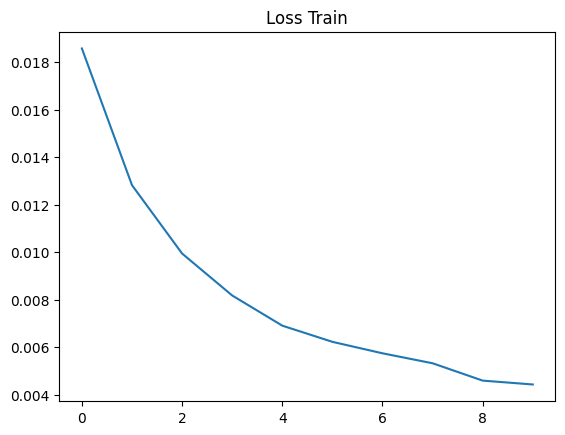

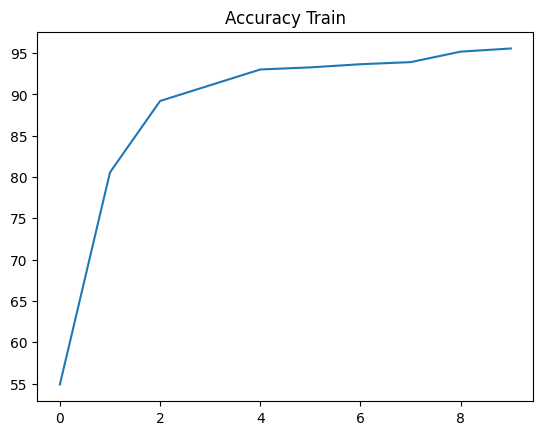

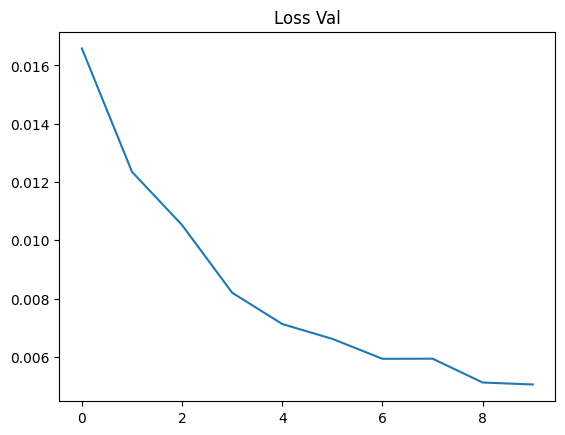

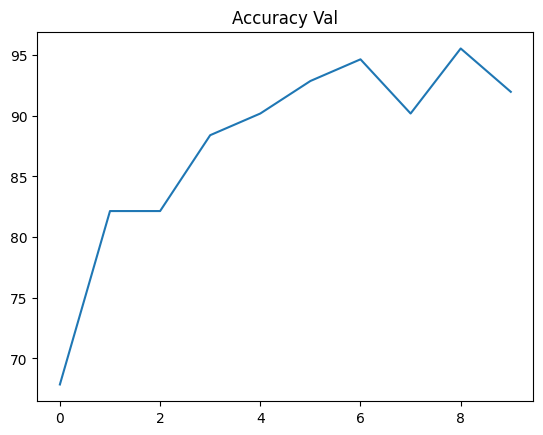

In [118]:
plt.plot(loss_list_train)
plt.title("Loss Train")
plt.show()
plt.plot(accuracy_list_train)
plt.title("Accuracy Train")
plt.show()
plt.plot(loss_list_val)
plt.title("Loss Val")
plt.show()
plt.plot(accuracy_list_val)
plt.title("Accuracy Val")
plt.show()


### Test [4 points]
Following your analysis, report the confusion matrix for the best model you obtained (with the criteria you defined). Then, report the accuracy, precision, recall and $F_1$ score for the best model. In all of the metrics, use macro averaging.

0.9318032800159648
0.9354886372302296
0.9292888512291652
0.9336283185840708


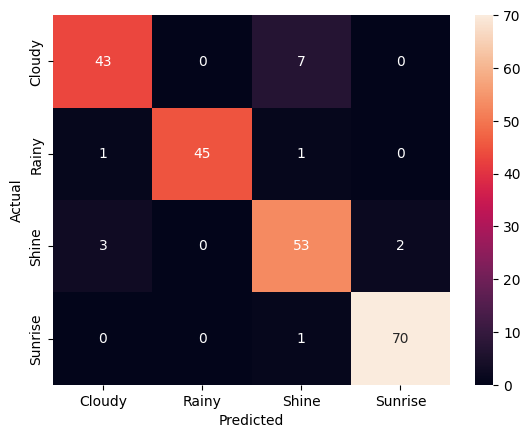

In [130]:
test_loader = DataLoader(test_dataset, batch_size=test_batch, shuffle=True)
y_pred = np.array([])
y_true = np.array([])
for i, (data, labels) in enumerate(test_loader):
    output = model(data)
    predicted = output.argmax(dim = 1, keepdim=True).squeeze()
    y_pred = np.append(y_pred, predicted)
    y_true = np.append(y_true, labels)

#TODO: print f1 score macro precision and recall and accuracy
print(f1_score(y_true, y_pred, average='macro'))
print(precision_score(y_true, y_pred, average='macro'))
print(recall_score(y_true, y_pred, average='macro'))
print(accuracy_score(y_true, y_pred))

#TODO: print confusion matrix as a heatmap
conf_mat = confusion_matrix(y_true, y_pred)
sns.heatmap(conf_mat, annot=True, fmt='d',
            xticklabels=["Cloudy","Rainy", "Shine", "Sunrise"], yticklabels=["Cloudy","Rainy", "Shine", "Sunrise"])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

### Discussion [3 points]
Now discuss the effectiveness of Transfer Learning. How does it improve performance?  

As it can be seen, transfer learning has made better performance in terms of accuracy. This happened due to 2 reasons. First reason is that resnet model has a more complex internal neural network architecture compared to our 2 models. Also, as the model is pretrained, its starting weights are more optimized. This creates a better starting point compared to our own models. The combination of better starting point and more optimized weights yields into more efficient performance.

# References
[1] Ajayi, Gbeminiyi (2018), “Multi-class Weather Dataset for Image Classification”, Mendeley Data, V1, doi: 10.17632/4drtyfjtfy.1